In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-hzjs9czt
  Running command git clone -q https://github.com/modAL-python/modAL.git /tmp/pip-req-build-hzjs9czt
  Created wheel for modAL: filename=modAL-0.4.1-py3-none-any.whl size=27938 sha256=df181fe5e8198d9cf87673cdaf4205a18f351b83eec7bab91735496031602769
  Stored in directory: /tmp/pip-ephem-wheel-cache-kk3q0_k6/wheels/c1/2f/cc/f2157ab6d756e6ef8f9b2165f1baa6be615c9f25b93661957a
Successfully built modAL


In [ ]:
from pathlib import Path
import sys, os

import copy
import itertools
import numpy as np
import pandas as pd
import random
import pickle as pkl
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy.special import ndtr
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import svm
from sklearn.gaussian_process.kernels import Matern, RBF,WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import Dataset
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models   # models.vgg16()
from torchsummary import summary

from modAL.utils.selection import multi_argmax
from modAL.models import BayesianOptimizer, ActiveLearner, CommitteeRegressor, Committee
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling, KL_max_disagreement, max_disagreement_sampling

import copy

### Set random seed
seed = 101
random.seed(seed)
np.random.seed(seed)

# path
proj_path = Path("/content/drive/MyDrive/LMAB/LMAB2/phenotype project")
data_path = proj_path/"data"
output_path = proj_path/"output"
def mkdir_if_ne(path):
    if not os.path.exists(path): os.mkdir(path)
mkdir_if_ne(output_path)
mkdir_if_ne(data_path)
print(f"proj_path: {data_path}")
sys.path.append(str(data_path.parent))

proj_path: /content/drive/MyDrive/LMAB/LMAB2/phenotype project/data


### Organize data
We need organize as follow:


*   Experiment Sample Space needs to be the data to be queried (X_query)
*   Experiment sets:
    *   Training data: ground truth
    *   Test data :(same everytime) evaluate model performance 

*   To-do in each iterations:
    *   Remove (drop) the rows that are used ( presented in training data)
    *   Save the rows that were used for query to output the next batch of experiment
    *   Save the learner, model as it goes


### Dataset (initial set-up)

In [1]:
## load whole dataset
our_sim_df = pd.read_csv(data_path/"raw"/"Our_drug_simulation_dataset.csv", index_col=0).drop_duplicates()
research_sim_df = pd.read_csv(data_path/"raw"/"previous_research_dataset.csv").drop_duplicates()
print(our_sim_df.shape, research_sim_df.shape)

NameError: ignored

In [ ]:
# Load initial datasets
test_data_df = pd.read_csv(data_path/"RECORD_TEST_results.csv", index_col=0)  # HOLD OUT set for testing model performance
train_data_df = pd.read_csv(data_path/"EXP_RESULT_batch0.csv", index_col=0)
query_df = pd.read_csv(data_path/"QUERY_SPACE_batch0.csv",index_col=0)
print("Dataset shape:", test_data_df.shape, train_data_df.shape, query_df.shape)
test_data_df.head(2)
query_df.head(2)
train_data_df.head(2)

Dataset shape: (54, 5) (54, 5) (14587, 4)


,(+)-Griseofulvin,(S)-(+)-Camptothecin,Chloramphenicol,Metformin,Cell viability
0,1.0,2.0,0.000,0.5,0.707
1,64.0,2.0,3.125,128.0,0.636


In [ ]:
### Using sim_df as training data
train_data_df = our_sim_df
# SMALL SAMPLE data df
train_data_df = train_data_df.loc[np.random.choice(train_data_df.index, size=300)]

In [ ]:
()### Load data  (from full dataset)
def load_Xy(df_data):
    """load xy"""
    # Load as x,y
    print(df_data.shape)
    X, y = df_data.iloc[:,:-1], df_data.iloc[:,-1]
    return X.to_numpy(), y.to_numpy()

# train_test_split
def init_train(df_data, init_size:float=0.2, exact_init:int =None):
    """split to initial and train/test set
    n_init: number of initial training sample
    """
    ## Initial training data
    ### TO DO
    data_size = len(df_data)
    X, y = df_data.iloc[:,:-1].to_numpy(), df_data.iloc[:,-1].to_numpy()
    if exact_init is None:
        initial_idx = np.random.choice(range(len(X)), size=max(1,round(data_size*init_size)), replace=False)   # should not be more than 50% of dataset
    else:
        initial_idx = np.random.choice(range(len(X)), size=max(1,exact_init), replace=False)
    X_init, y_init = X[initial_idx], y[initial_idx]
    
    ok_to_use_idx = np.delete(range(len(X)), initial_idx)
    X_train = X[ok_to_use_idx]
    y_train = y[ok_to_use_idx]
    #
    random.seed(seed); random.shuffle(X_train)
    random.seed(seed); random.shuffle(y_train)
    return (X_init, y_init), (X_train, y_train)

#  Exception, use all for initiation
#  X_init, y_init = X_train_full, y_train_full

In [ ]:
# test
(X_test, y_test), _ = init_train(test_data_df, init_size=1)  # use all
#
#(X_train_full, y_train_full), _ = init_train(train_data_df, init_size=1)  # use all
# use percent
(X_init, y_init), (X_train, y_train) = init_train(train_data_df, init_size=0.25)  # use all
# use exact
(X_init, y_init), (X_train, y_train) = init_train(train_data_df, exact_init=5)  # use all
print("Initialize shape:", X_init.shape, y_init.shape,"Training shape:", X_train.shape, y_train.shape)
#
X_query = query_df.to_numpy()
print(X_query.shape)

Initialize shape: (5, 4) (5,) Training shape: (295, 4) (295,)
(14587, 4)


In [ ]:
### Optional
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

### Candidate Models

In [ ]:
class NNClassifier(object):
    def __init__(self,
                 feature_n,
                 class_n=1,
                 hidden_n = 30,
                 learning_rate = 4e-3,
                 weight_decay = 1e-5):
        self.model = torch.nn.Sequential(torch.nn.Linear(feature_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,class_n))
        self.lr = learning_rate
        self.wd = weight_decay

    def fit(self,X_train,y_train,epoches = 300,batch_size = 50):
        X_t = torch.from_numpy(X_train.astype(np.float32))
        y_t = torch.from_numpy(y_train.astype(np.int64))
        dataset = TensorDataset(X_t, y_t)
        loader = DataLoader(dataset,batch_size = batch_size,shuffle = True)
        loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr,weight_decay=self.wd)
        loss_record = 0.0
        report_epoch = 50
        for epoch_i in range(epoches):
            for batch in loader:
                x_batch,y_batch = batch
                y_pred = self.model(x_batch)
                loss = loss_fn(y_pred,y_batch)
                self.model.zero_grad()
                loss.backward()
                optimizer.step()
                loss_record += loss.item()
            if epoch_i%report_epoch == report_epoch-1:
                print("[%d|%d] epoch loss:%.2f"%(epoch_i+1,epoches,loss_record/report_epoch))
                loss_record = 0.0
            if epoch_i>=epoches:
                break
    
    def score(self, X_test,y_test):
        X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
        y_pred_test = self.model(X_test_tensor)
        y_output = torch.argmax(y_pred_test,axis = 1).numpy()
        return (y_output == y_test).mean()
        
    def predict(self, X, return_std=False):
        X_tensor = torch.from_numpy(X.astype(np.float32))
        pred = self.model(X_tensor)
        if return_std:
            return torch.argmax(pred, axis = 1).numpy(), np.std(pred.detach().numpy(), axis=1)
        else:
            return torch.argmax(pred, axis = 1).numpy()

from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize

class GaussianProcessRegressor2(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=15000, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        def new_optimizer(obj_func, initial_theta, bounds):
            return scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                max_iter=self._max_iter,
            )
        self.optimizer = new_optimizer
        return super()._constrained_optimization(obj_func, initial_theta, bounds)

In [ ]:
# Initialize Candidate models
    ## SVR
SVR_clf = svm.SVR(kernel='rbf', degree=3, epsilon=0.1, C=1)
    ## NN
nn = NNClassifier(feature_n = X_train.shape[1], hidden_n = 50)
    ## RF
rf = RandomForestRegressor(n_estimators = 20, 
                            max_depth = 6, random_state = seed)

### Query Strategies
*   Metric (uncertainty) measurement
*   Estimator Models



In [ ]:
from modAL.acquisition import max_EI, max_UCB

In [ ]:
## Query Strategy
def random_query(regressor, X, **kargs):
    ran_idx = random.choice(range(len(X)))
    return ran_idx, X[ran_idx]

def regression_std(regressor, X, return_only_idx=False):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    if return_only_idx: return query_idx
    else: return query_idx, X[query_idx]

# query strategy for regression
def ensemble_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

In [ ]:
# Learners
#params
RBF_kernel = Matern(length_scale=1) #+ WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-5, 1))
RBF_kernel2 = RBF(length_scale=1.0)

# Learners 
learner_gp_regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=RBF_kernel),
    query_strategy=regression_std,
    X_training=X_init, y_training=y_init
)

learner_max_svr = ActiveLearner(
    estimator=SVR_clf,
    query_strategy=regression_std,
    X_training=X_init, y_training=y_init
)
learner_rand = ActiveLearner(
    estimator=rf,
    query_strategy=random_query,
    X_training=X_init, y_training=y_init
)
################################################################################
# Bayesian Optimizer
# with GP
learner_gp_maxei = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=RBF_kernel2),
    query_strategy=max_EI,
    X_training=X_init, y_training=y_init,
    bootstrap_init=True
)
learner_nn_maxei = BayesianOptimizer(
    estimator=nn,
    query_strategy=max_EI,
    X_training=X_init, y_training=y_init,
    bootstrap_init=True
)
#with Random Forest
class rfwapper(RandomForestRegressor):
    def predict(self, X, return_std = False):
      ys = np.array([e.predict(X) for e in self.estimators_])
      if return_std:
          return np.mean(ys, axis = 0).ravel(), np.nanstd(ys, axis = 0).ravel()
      return super().predict(X).ravel()

################################################################################
# Create learner objects
classifiers = [learner_gp_regressor, learner_max_svr]
learner_list = []

for classifier in classifiers:
    # initializing learner
    learner = ActiveLearner(
        estimator=classifier,
        X_training=X_init, y_training=y_init
        )
    learner_list.append(learner)

# committee learner
learner_committee = CommitteeRegressor(
      learner_list=learner_list,
      query_strategy=ensemble_regression_std,
      )

[50|300] epoch loss:0.00
[100|300] epoch loss:0.00
[150|300] epoch loss:0.00
[200|300] epoch loss:0.00
[250|300] epoch loss:0.00
[300|300] epoch loss:0.00


In [ ]:
learner_rand.query(X_train)

(181, array([6.4e+01, 5.0e-01, 8.0e+02, 4.0e+00]))

In [ ]:
print(*learner_gp_maxei.query(X_train, n_instances=3), sep='\n')
print(learner_gp_maxei.predict([X_train[0]], return_std=True))
print(learner_gp_maxei.get_max())

[ 11  96 112]
[[1.0e+00 2.5e-01 4.0e+02 0.0e+00]
 [1.0e+00 2.5e-01 4.0e+02 0.0e+00]
 [1.0e+00 2.5e-01 4.0e+02 0.0e+00]]
(array([0.]), array([1.]))
(array([ 0.125,  2.   , 50.   , 64.   ]), 0.999)


In [ ]:
def EI(mean, std, max_val, tradeoff):
    z = (mean - max_val - tradeoff) / std
    return (mean - max_val - tradeoff)*ndtr(z) + std*norm.pdf(z)

def optimizer_EI(optimizer, X, tradeoff: float = 0) -> np.ndarray:
    """
    Expected improvement acquisition function for Bayesian optimization.

    Args:
        optimizer: The :class:`~modAL.models.BayesianOptimizer` object for which the utility is to be calculated.
        X: The samples for which the expected improvement is to be calculated.
        tradeoff: Value controlling the tradeoff parameter.

    Returns:
        Expected improvement utility score.
    """
    try:
        mean, std = optimizer.predict(X, return_std=True)
        mean, std = mean.reshape(-1, ), std.reshape(-1, )
    except NotFittedError:
        mean, std = np.zeros(shape=(X.shape[0], 1)), np.ones(shape=(X.shape[0], 1))

    return EI(mean, std, optimizer.y_max, tradeoff)


def max_EI(optimizer, X, tradeoff: float = 0,
           n_instances: int = 1) :
    """
    Maximum EI query strategy. Selects the instance with highest expected improvement.

    Args:
        optimizer: The :class:`~modAL.models.BayesianOptimizer` object for which the utility is to be calculated.
        X: The samples for which the expected improvement is to be calculated.
        tradeoff: Value controlling the tradeoff parameter.
        n_instances: Number of samples to be queried.

    Returns:
        The indices of the instances from X chosen to be labelled; the instances from X chosen to be labelled.
    """
    ei = optimizer_EI(optimizer, X, tradeoff=tradeoff)
    query_idx = multi_argmax(ei, n_instances=n_instances)

    return query_idx, X[query_idx]


### Query & Train: Main loop

### Experiment mode

In [ ]:
class train_evaluate:
    def __init__(self, train_data: tuple, test_data:tuple, settings):
        """
        train_data (tuple)
        test_data (tuple)
        settings(dict)
        """
        self.settings = settings
        self.train_data = train_data   
        self.X_test, self.y_test = test_data

        self.debug = settings['debug']
        #
        self.query_batch_size = self.settings["query_batch_size"]
        # 
        self.metric = ["r2", "score", "estimator_metric"]
        self.metrics = defaultdict(list, {k:[] for k in self.metric})

    def main(self, learners):
        """
        params:
            learners  (dict[dict[listt]]): dictkeys(model names)[learner object]
        return:
            history (dict[dict[listt]]): dictkeys(model names)[dictkeys(metric nmes)]
        """
        self.learner_names = list(learners.keys())
        self.learners = learners
        # duplicate data for each learner
        split = lambda x: np.array(np.array_split(x, n_batch))   # function for splitting data
        self.learner_data = dict.fromkeys(learners, None)
        for name in learners:
            self.learner_data[name] = {"train": copy.deepcopy(self.train_data)}
        split = lambda xy: np.array(np.array_split(xy, n_batch))   # function for splitting data
        print(f"Dataset size: {len(self.train_data[0])}")
        # Initialized data collection
        self.history = {k: self.metrics for k in self.learner_names}

        for n, (learner_name, learner) in enumerate(self.learners.items()):
            batch_idx = 0
            data_len = np.inf
            print(f"Learner name: {learner_name}")
            while data_len > self.query_batch_size:
                batch_idx += 1; print(f"Round: {batch_idx}\nData left: {data_len}")
                # Query selection and train
                query_idx = self.query_and_teach(learner, learner_name)
                data_len = len(self.learner_data[learner_name]["train"][0])
                if self.debug: print("Query:", query_idx , "\nlearner:", learner_name)
                # Add result
                self.add_result(batch_idx)
            self.n_batch = batch_idx
            #
            self.save_json(learner_name)
        #
        self.plot_convergence()
        # 
        return self.get_final()

    def query_and_teach(self, learner, learner_name):
        # Query train
        x_data , y_data = self.learner_data[learner_name]["train"]
        for i in range(self.query_batch_size):
            if self.debug: print("X, y shape:", x_data.shape, y_data.shape)
            query_idx, query_instance = learner.query(x_data)
            x_inst = x_data[query_idx].reshape((1,-1))
            y_inst = y_data[query_idx].reshape(-1)
            if self.debug: print("Query IDX:", query_idx, "instance:", x_inst, y_inst)
            learner.teach(x_inst, y_inst)
            x_data = np.delete(x_data, query_idx, axis=0)
            y_data = np.delete(y_data, query_idx)
        # Any additional Info
        self.learner_data[learner_name]["train"] = (x_data, y_data)
        return query_idx

    def add_result(self, idx):
        # Add results
        for (name, learner) in self.learners.items():
            # if method can return std
            if name != "Random":
                y_pred, y_std = learner.predict(self.X_test, return_std=True)
                self.history[name]['estimator_metric'].append(y_std)
            else:
                y_pred = learner.predict(self.X_test)
            if self.debug: print(self.y_test.shape, self.y_pred.shape)
            r2 = r2_score(self.y_test, y_pred)
            score = learner.score(X_test, self.y_test)
            # save to history
            self.history[name]["r2"].append(r2)
            self.history[name]["score"].append(score)
            
            print(f"Round {idx}: Test R2 for {name}: {r2} \n Score: {score} \n STD: {y_std}")

    def save_json(self, name):
        # Save 
        try: 
            save_name = f'Query-{name}_evaluation_history.json'
            with open(output_path/save_name, 'w') as fp: json.dump(self.history[name], fp,cls=NumpyEncoder)
            print(f"Saved to {save_name}")
        except:
            print("Failed to save as json.")
        
    def plot_convergence(self):
        # Plot convergence 
        fig, ax = plt.subplots(1,2, figsize=(12,5),sharey=True); fig.legend([])
        for name, learner in learners.items():
            for plot_idx, metric in enumerate(["r2", "score"]):
                ax[plot_idx].plot(range(len(self.history[name][metric])), self.history[name][metric], label=name);
                ax[plot_idx].set_title(metric);  ax[0].legend(); #ax[0].set_ylim([0.2, 1]);
    
    def get_final(self):
        # Final prediction
        performance =  {k: {m: None for m in self.metric} for k in self.learner_names}
        for name in performance:
            y_pred_test_final = self.learners[name].predict(self.X_test)
            performance[name]["r2"] = r2_score(self.y_test, y_pred_test_final) 
            print(y_test, performance[name]["score"], self.learners[name].predict(self.X_test))
            print("R2 score",performance[name]["r2"])
        return self.history, performance

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
# Query settings
bs = 5
n_batch = len(X_train)//bs
evaluate_settings = {"query_batch_size": max(1, bs),  # Usually =1 (all data as 1 batch no split)
                     "n_batch": max(1, n_batch),
                     "debug": False
                    }

Dataset size: 221
Learner name: Random
Round: 1
Data left: inf
Round: 2
Data left: 216
Round: 3
Data left: 211
Round: 4
Data left: 206
Round: 5
Data left: 201
Round: 6
Data left: 196
Round: 7
Data left: 191
Round: 8
Data left: 186
Round: 9
Data left: 181
Round: 10
Data left: 176
Round: 11
Data left: 171
Round: 12
Data left: 166
Round: 13
Data left: 161
Round: 14
Data left: 156
Round: 15
Data left: 151
Round: 16
Data left: 146
Round: 17
Data left: 141
Round: 18
Data left: 136
Round: 19
Data left: 131
Round: 20
Data left: 126
Round: 21
Data left: 121
Round: 22
Data left: 116
Round: 23
Data left: 111
Round: 24
Data left: 106
Round: 25
Data left: 101
Round: 26
Data left: 96
Round: 27
Data left: 91
Round: 28
Data left: 86
Round: 29
Data left: 81
Round: 30
Data left: 76
Round: 31
Data left: 71
Round: 32
Data left: 66
Round: 33
Data left: 61
Round: 34
Data left: 56
Round: 35
Data left: 51
Round: 36
Data left: 46
Round: 37
Data left: 41
Round: 38
Data left: 36
Round: 39
Data left: 31
Round: 40

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 17
Data left: 141


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 18
Data left: 136


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 19
Data left: 131


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 20
Data left: 126


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 21
Data left: 121
Round: 22
Data left: 116


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 23
Data left: 111


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 24
Data left: 106


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 25
Data left: 101


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 26
Data left: 96


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 27
Data left: 91


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 28
Data left: 86


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 29
Data left: 81


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 30
Data left: 76


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 31
Data left: 71
Round: 32
Data left: 66


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 33
Data left: 61


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 34
Data left: 56


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 35
Data left: 51


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 36
Data left: 46
Round: 37
Data left: 41


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 38
Data left: 36


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 39
Data left: 31


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 40
Data left: 26
Round: 41
Data left: 21


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 42
Data left: 16


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Round: 43
Data left: 11


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Round: 44
Data left: 6


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Saved to Query-GP Regressor RBF: Max EI_evaluation_history.json
[0.997 0.998 0.994 0.999 0.992 0.999 0.999 0.939 0.84  0.996 0.999 0.997
 0.995 1.    0.996 0.97  0.996 0.994 0.998 0.997 0.999 0.963 0.999 0.999
 0.999 1.    1.    1.    0.966 1.    0.997 0.995 0.999 0.892 0.991 0.992
 1.    0.999 0.999 0.999 1.    0.992 0.993 0.999 1.    0.999 0.997 0.999
 0.99  0.907 0.999 0.987 0.925 1.    0.97  0.997 0.967 0.994 0.981 0.991
 0.999 1.    1.    0.998 0.996 0.932 0.996 1.    1.    0.985 0.484 0.998
 0.99  0.991] None [0.99603121 0.94976579 0.96804194 0.99885476 0.99785987 0.99785987
 0.94976579 0.982889   0.97799148 0.9856214  0.24581667 0.99429008
 0.99868404 0.99148898 0.99006536 0.97519981 0.99297063 0.99839482
 0.97566725 0.98987324 0.99373915 0.94819197 0.98267737 0.24581667
 0.9351724  0.969995   0.99599964 0.96125996 0.95363572 0.99878018
 0.993858   0.99086708 0.84344551 0.98284789 0.99088017 0.99444791
 0.99776791 0.8585804  0.99699783 0.80685938 0.99868404 0.99391053
 0.9826713

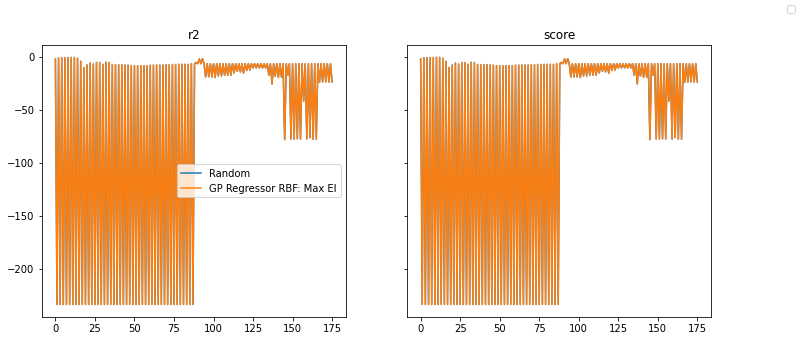

In [ ]:
# Learner objects. [random_learner, selected_learner]
learners =  {"Random": learner_rand, 
             #"GP Regressor: regression std": learner_gp_regressor,
             "GP Regressor RBF: Max EI": learner_gp_maxei
             }
#             
train_AL = train_evaluate((X_train, y_train), (X_test, y_test), settings=evaluate_settings)
eval_history, performance = train_AL.main(learners)


In [ ]:
batch_history['GP Regressor RBF: Max EI']['r2']

[-3.7551094955768365,
 -49.556386813910564,
 -3.4398900460449138,
 -49.556386813910564,
 -2.896267302608602,
 -49.556386813910564,
 -3.0734159314588947,
 -49.556386813910564,
 -3.1236982731237237,
 -49.556386813910564,
 -3.08127127485069,
 -49.556386813910564,
 -3.1166575195188155,
 -49.556386813910564,
 -3.262274722490745,
 -49.556386813910564,
 -3.199874747647198,
 -49.556386813910564,
 -3.231674003638628,
 -49.556386813910564,
 -3.1859445012329495,
 -49.556386813910564,
 -3.287959972701806,
 -49.556386813910564,
 -3.2704258239404034,
 -49.556386813910564,
 -3.2227662733192295,
 -49.556386813910564,
 -3.430238664924623,
 -49.556386813910564,
 -3.209877960059562,
 -49.556386813910564,
 -3.0887337784524203,
 -49.556386813910564,
 -3.242177221258495,
 -49.556386813910564,
 -3.1163240373920527,
 -49.556386813910564,
 -3.1275537046517776,
 -49.556386813910564,
 -3.047499325439227,
 -49.556386813910564,
 -3.090105615465653,
 -49.556386813910564,
 -3.0306310559480076,
 -49.556386813910564,


### Batch production of next query round

In [ ]:
def query_and_evaluate(train_data:tuple, test_data: tuple, 
                       X_query:np.array,
                       learners, 
                       settings):
    """
    params:
        learners  (dict[dict[listt]]): dictkeys(model names)[learner object]
    # Variables:
        learner_data   (dict[dict[listt]])
    return:
        history (dict[dict[listt]]): dictkeys(model names)[dictkeys(metric nmes)]
    """
    n_batch = max(1, len(train_data[0])/settings["batch_size"])
    print(f"Number of batches:{n_batch}")
    train_data, test_data = copy.deepcopy(train_data), copy.deepcopy(test_data)
    query_data = copy.deepcopy(X_query)
    print(f"Train Dataset size: {len(train_data[0])}")
    print(f"Test Dataset size: {len(test_data[0])}")

    # Initialized data collection
    history = dict()
    metric = ["r2", "score"]
        # other keys
    other_data = ["query_idx"]
    metrics = defaultdict(list, {k:[] for k in metric})
    history["metrics"] = {k: metrics for k in learners}
    history["query_idx"] = {k: [] for k in learners}
    print(f"History schema:{history}")
    # duplicate data for each learner
    split = lambda x: np.array(np.array_split(x, n_batch))   # function for splitting data
    learner_data = dict.fromkeys(learners, 0)
    for name in learners:
        learner_data[name] = {"train": copy.deepcopy(train_data), "query": copy.deepcopy(query_data)}
    # Training
    for n, (name, learner) in enumerate(learners.items()):
        if settings["debug_logging"]: print("learner:", name)
        X_train, y_train = learner_data[name]["train"]
        
        for idx, (X_datum, y_datum) in enumerate(zip(split(X_train), split(y_train))):
            # Query train
            if settings["debug_logging"]: print(f"Round:{idx}, Batch shape: {X_datum.shape}")
            learner.teach(X_datum, y_datum)
    #################################
    # fresh batch query
    batch_number = 1
    for n, (name, learner) in enumerate(learners.items()):
        while len(history['query_idx'][name]) < settings['query_size'] and len(learner_data[name]['query']) > 1:  # loop until sufficient query
            if settings["debug_logging"]: 
                print(f"\t Batch number:{batch_number}")
                print(f"Remaining query shape: {learner_data[name]['query'].shape}")
            # Query selection
            query_idx, query_instance = learner.query(learner_data[name]["query"])
            learner_data[name]["query"] = np.delete(learner_data[name]["query"], idx, axis=0)
            # add counts
            for i, conc_ in enumerate(query_instance.flatten()):
                conc_counts[name][i][conc_] += 1
            # check constraints
            constraint_func = settings['query_constraint']
            violated, pof = constraint_func(name, query_instance)
            if not constraint_func is None and violated:
                (i, c) = pof
                qdf_ = pd.DataFrame(learner_data[name]["query"])
                learner_data[name]["query"] = qdf_[qdf_[i] !=c].to_numpy()
                print(f"Dropped concentration due to experiment violateion for: {pof}")
            else: history['query_idx'][name].append(query_idx)      
            batch_number += 1
            
    # Final prediction
    performance =  {k: {m: None for m in metric} for k in learners}
    for name, learner_name in zip(performance, learners):  # 
        y_pred = learners[learner_name].predict(X_test)
        performance[name]["r2"] = r2_score(y_test, y_pred)
    return history, performance

def rand_query(query_df, size=54):
    return query_df.reset_index().loc[np.random.choice(range(len(query_df)), size=size)]
######################################################3
## Run query, training loop
n_queries=300
# Learner objects. [random_learner, selected_learner]
learners =  {"Random": learner_rand, 
             "GP Regressor:regression std": learner_gp_regressor}

# Constraint # experiment constraints (for each query)
dilutions = np.unique(X_query[:,0])
    # initialized counts for each dilutions for each compound
conc_counts = {k: {k: 0 for k in dilutions} for k in range(X_query.shape[1])}  
    # for each learner
conc_counts = {k: conc_counts for k in learners}

def violate_exp_constraint(name, query_instance, limit_occur=10, **kwargs):
    '''check query if violates experiment constraints'''
    for i, conc_ in enumerate(query_instance.flatten()):
        if conc_counts[name][i][conc_] > limit_occur:
            return True, (i, conc_)
    return False, False

In [ ]:
# Query settings
bs=54
qs = 54
print(bs, qs)
query_settings = {"query_size": qs,
                  "batch_size": max(1, bs),  # Usually =1 (all data as 1 batch no split)
                  "debug_logging": True,
                  "query_constraint": violate_exp_constraint}
print(X_train.shape, y_train.shape, X_query.shape)
batch_history, performance = query_and_evaluate((X_train, y_train), (X_test, y_test), X_query, learners, settings=query_settings)

54 54
(40, 4) (40,) (14586, 4)
Number of batches:1
Train Dataset size: 40
Test Dataset size: 54
History schema:{'metrics': {'Random': defaultdict(<class 'list'>, {'r2': [], 'score': []}), 'GP Regressor:regression std': defaultdict(<class 'list'>, {'r2': [], 'score': []})}, 'query_idx': {'Random': [], 'GP Regressor:regression std': []}}
learner: Random
Round:0, Batch shape: (40, 4)
learner: GP Regressor:regression std
Round:0, Batch shape: (40, 4)
	 Batch number:1
Remaining query shape: (14586, 4)
	 Batch number:2
Remaining query shape: (14585, 4)
	 Batch number:3
Remaining query shape: (14584, 4)
	 Batch number:4
Remaining query shape: (14583, 4)
	 Batch number:5
Remaining query shape: (14582, 4)
	 Batch number:6
Remaining query shape: (14581, 4)
	 Batch number:7
Remaining query shape: (14580, 4)
	 Batch number:8
Remaining query shape: (14579, 4)
	 Batch number:9
Remaining query shape: (14578, 4)
	 Batch number:10
Remaining query shape: (14577, 4)
	 Batch number:11
Remaining query shap

In [ ]:
## log to batch history
hist_df = pd.DataFrame(batch_history)
hist_df.to_csv(data_path/"BatchLogging.csv")
hist_df.head(2)

,metrics,query_idx
Random,"{'r2': [], 'score': []}","[10686, 13490, 10238, 11143, 5382, 10891, 1407..."
GP Regressor:regression std,"{'r2': [], 'score': []}","[0, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14,..."


In [ ]:
chose_learner = "GP Regressor:regression std"
query_idx = hist_df["query_idx"][chose_learner]
query_round_df = query_df.reset_index(drop=True).loc[query_idx]
query_round_df.columns = test_data_df.columns[:-1]
print(query_round_df.shape)
query_round_df.head(2)

(28, 4)


,(+)-Griseofulvin,(S)-(+)-Camptothecin,Chloramphenicol,Metformin
0,128.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0


In [ ]:
# Add random
#query_rand_df = rand_query(query_df, size=54-28)
#query_round_df = pd.concat([query_round_df, query_rand_df])

In [ ]:
# Save 
round_number = 1
round_fn = f"QUERY_ROUND_batch{round_number}.csv"
query_round_df.to_csv(data_path/round_fn ,sep=",", index=False)
print(f"Saved to {round_fn}")

Saved to QUERY_ROUND_batch1.csv
